In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sb

%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score, cohen_kappa_score

from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectKBest
import warnings
warnings.filterwarnings('ignore')


### Datos

In [748]:
### Trabajar con el dataset original preprocesado para eliminar ruido, nulos y duplicados
data = pd.read_csv('../data/preprocessed.csv')

# ## Trabajar con todos los datos discretizados y una ventana de tiempo de dos días
# data = pd.read_csv('../data/discretized.csv')

data.keys()

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')

In [731]:
def ver_porcentaje_nulo(df):
    print('Number of instances = %d' % (df.shape[0]))
    print('Number of attributes = %d' % (df.shape[1]))
    print('---------------------------------------------------\n')
    print('Number of missing values:')
    for col in df.columns:
        num_missing = df[col].isna().sum()
        percentage_missing = (num_missing / df.shape[0]) * 100
        print('\t%s: %d missing (%.3f%%) %s' % (col, num_missing, percentage_missing, df[col].dtype))

In [ ]:
ver_porcentaje_nulo(data)

In [749]:
data = data.drop(columns=['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir9am', 'WindDir3pm', 'RainToday'])

factor_escala = 100000000  # Factor para aumentar la importancia de la característica
data['Sunshine'] = data['Sunshine'] * factor_escala
data['Rainfall'] = data['Rainfall'] * factor_escala
data['Humidity3pm'] = data['Humidity3pm'] * factor_escala

In [750]:
# Separar el conjunto de caracteristicas 'X' y la variable objetivo 'Y'
attributes = data.drop(['RainTomorrow'], axis=1)
target = data['RainTomorrow']

### Balanceo de clase RainTomorrow

In [ ]:
# pip install imbalanced-learn

In [751]:
# Ver la cantidad de muestras en las clases del dataset original
frecuencia_clases = target.value_counts()
print(frecuencia_clases)

No     58804
Yes    16821
Name: RainTomorrow, dtype: int64


In [752]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_resampled, Y_resampled = rus.fit_resample(attributes, target)


# Verificar la cantidad de muestras en las clases después del submuestreo
frecuencia_clases = Y_resampled.value_counts()
print(frecuencia_clases)

No     16821
Yes    16821
Name: RainTomorrow, dtype: int64


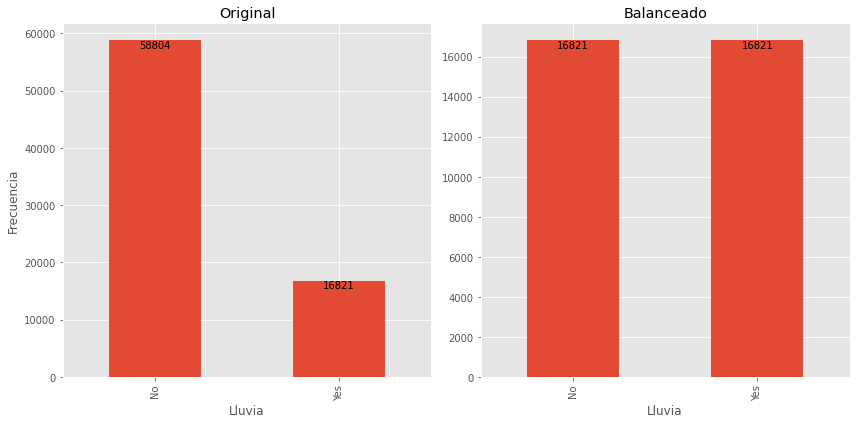

In [753]:
plt.figure(figsize=(12, 6))

# Grafica para la variable original
plt.subplot(121)
frecuencia_original = target.value_counts()
frecuencia_original.plot(kind='bar')

for index, value in enumerate(frecuencia_original):
    plt.text(index, value + 10, str(value), ha='center', va='top')
plt.title('Original')
plt.xlabel('Lluvia')
plt.ylabel('Frecuencia')

# Grafica para la variable balanceada
plt.subplot(122)
frecuencia_balanceada = Y_resampled.value_counts()
frecuencia_balanceada.plot(kind='bar')
for index, value in enumerate(frecuencia_balanceada):
    plt.text(index, value + 10, str(value), ha='center', va='top')
plt.title('Balanceado')
plt.xlabel('Lluvia')

plt.tight_layout()
plt.show()

### Selección de datos para trabajar

In [754]:
# Trabajar con el dataset normal
X_data = attributes
Y_data = target
dataset_trabajo = 'NORMAL'

# # Trabajar con las clases balanceadas
# X_data =  X_resampled
# Y_data = Y_resampled
# dataset_trabajo = 'BALANCEADO'


Y_data = Y_data.replace({'Yes': 1, 'No': 0})
dataframe = pd.concat([X_data, Y_data], axis=1)

print('Dataframe shape', dataframe.shape)

Dataframe shape (75625, 17)


### Visualización de los datos

Trabajando con el dataset  NORMAL


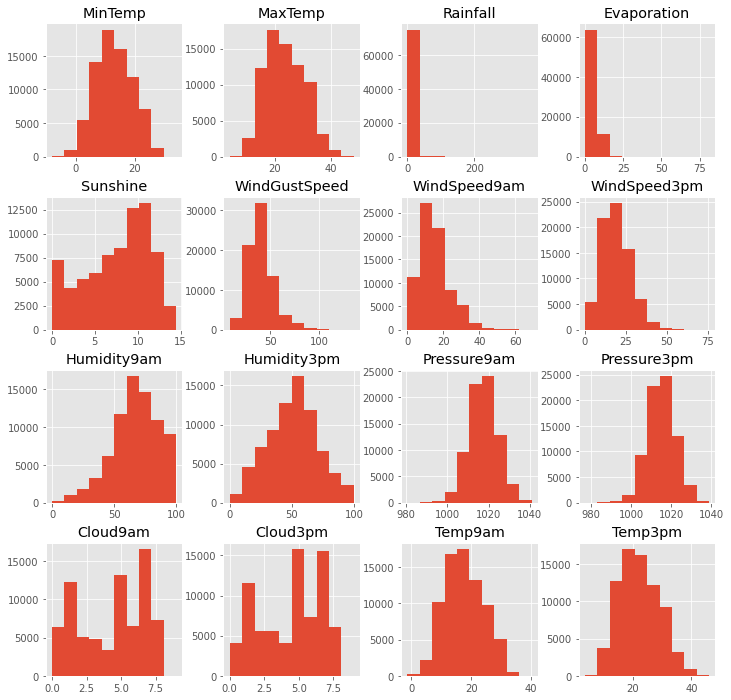

In [683]:
print('Trabajando con el dataset ', dataset_trabajo)
X_data.hist(figsize=(12, 12))
plt.show()

### Selección de caracteristicas

In [784]:
# Crear una instancia de SelectKBest que seleccionará las mejores n características (k=n)
best = SelectKBest(k=8)


X_new = best.fit_transform(X_data, Y_data)
X_new.shape
selected = best.get_support(indices=True)
print(X_data.columns[selected])

Index(['Rainfall', 'Sunshine', 'Humidity9am', 'Humidity3pm', 'Pressure9am',
       'Pressure3pm', 'Cloud9am', 'Cloud3pm'],
      dtype='object')


**Ver la correlación de las caracteristicas seleccionadas**

<AxesSubplot:title={'center':'Pearson Correlation of Features'}>

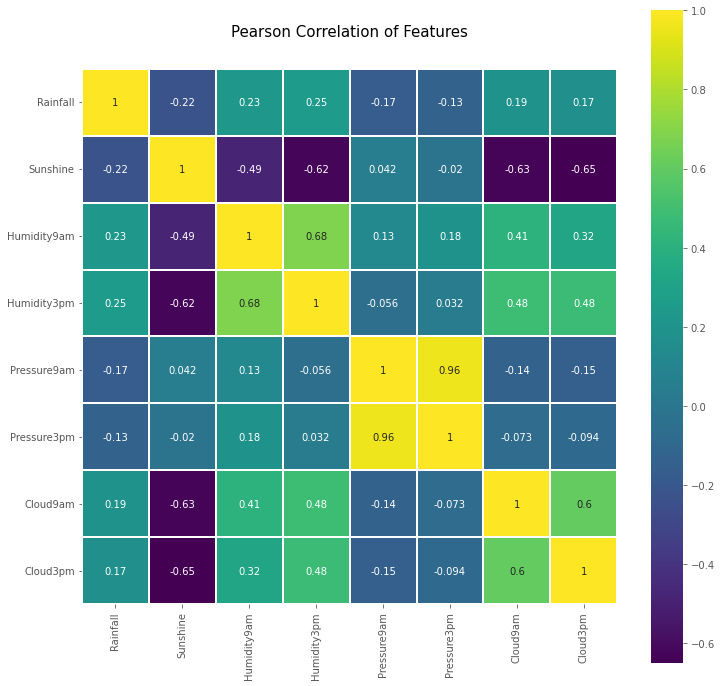

In [785]:
used_features = X_data.columns[selected]

colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sb.heatmap(dataframe[used_features].astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

### Dividir los datos en conjutos de prueba y entrenamiento 70/30

In [786]:
X_train, X_test = train_test_split(dataframe, test_size=0.3, random_state=6)
Y_train = X_train['RainTomorrow']
Y_test = X_test['RainTomorrow']

print('tamaño de los datos')
print('train: ', X_train.shape[0])
print('test: ', X_test.shape[0])
print('total: ', X_train.shape[0] + X_test.shape[0])

tamaño de los datos
train:  52937
test:  22688
total:  75625


## Modelo Naivve Bayes

In [787]:
# Instantiate the classifier
gnb = GaussianNB()
# Train classifier
gnb.fit(
    X_train[used_features].values,
    Y_train
)
y_pred = gnb.predict(X_test[used_features])

**Resultados**

In [788]:
print('Precisión en el set de Entrenamiento: {:.2f}'
     .format(gnb.score(X_train[used_features], Y_train)))
print('Precisión en el set de Test: {:.2f}'
     .format(gnb.score(X_test[used_features], Y_test))) 

Precisión en el set de Entrenamiento: 0.82
Precisión en el set de Test: 0.82


In [789]:
# Print Test results
print("Total de Muestras en Test: {}\nFallos: {}\nAciertos: {}"
      .format(
          X_test.shape[0],
          (Y_test != y_pred).sum(),
          (Y_test == y_pred).sum()
))

Total de Muestras en Test: 22688
Fallos: 4080
Aciertos: 18608


In [790]:
print('Clasificadoer naive bayes con dataset ', dataset_trabajo)
print('Matriz de confusión:')
print(confusion_matrix(Y_test, y_pred))
print('Reporte de clasificación')
print(classification_report(Y_test, y_pred))
print('Model accuracy')
print(accuracy_score(Y_test, y_pred))

Clasificadoer naive bayes con dataset  NORMAL
Matriz de confusión:
[[16388  1255]
 [ 2825  2220]]
Reporte de clasificación
              precision    recall  f1-score   support

           0       0.85      0.93      0.89     17643
           1       0.64      0.44      0.52      5045

    accuracy                           0.82     22688
   macro avg       0.75      0.68      0.71     22688
weighted avg       0.81      0.82      0.81     22688

Model accuracy
0.8201692524682651


## Pruebas otros enfoques

### Con el dataset discretizado

In [254]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd


# Crear un DataFrame a partir de los datos
df = pd.read_csv('../data/discretized.csv')

# Convertir características categóricas a valores numéricos usando LabelEncoder
label_encoder = LabelEncoder()
df_encoded = df.apply(label_encoder.fit_transform)

# Separar las características y la variable objetivo
X = df_encoded.drop('RainTomorrow', axis=1)
y = df_encoded['RainTomorrow']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Inicializar el clasificador Naive Bayes Multinomial
nb_classifier = MultinomialNB()

# Entrenar el clasificador
nb_classifier.fit(X_train, y_train)

# Hacer predicciones
y_pred = nb_classifier.predict(X_test)

# Evaluar el rendimiento del clasificador (exactitud en este caso)
accuracy = nb_classifier.score(X_test, y_test)
print(f'Precisión del clasificador: {accuracy:.2f}')

print('Matriz de confusión:')
print(confusion_matrix(y_test, y_pred))
print('Reporte de clasificación')
print(classification_report(y_test, y_pred))
print('Model accuracy')
print(accuracy_score(y_test, y_pred))

Precisión del clasificador: 0.72
Matriz de confusión:
[[12463  4193]
 [ 1710  2775]]
Reporte de clasificación
              precision    recall  f1-score   support

           0       0.88      0.75      0.81     16656
           1       0.40      0.62      0.48      4485

    accuracy                           0.72     21141
   macro avg       0.64      0.68      0.65     21141
weighted avg       0.78      0.72      0.74     21141

Model accuracy
0.7207795279315075


### Probar con usa sola ciudad y normalizando

In [525]:
# Trabajar con el dataset original preprocesado para eliminar ruido, nulos y duplicados

data = pd.read_csv('../data/preprocessed.csv')

#Exploraremos una sola ciudad para ver como estan distribuidas las variables
location_df = data[data['Location']=='Nuriootpa'] #Nuriootpa , Canberra ...

location_df['RainToday'] = location_df['RainToday'].replace({'Yes': 1, 'No': 0})
location_df['RainTomorrow'] = location_df['RainTomorrow'].replace({'Yes': 1, 'No': 0})

location_df = location_df.drop(columns=['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm'])


# # Normalización de los datos -------------------------------------------------------------------
# data_not_normalize = pd.DataFrame(location_df[['RainToday', 'RainTomorrow']])

# scaler = MinMaxScaler()
# # Normalizar solo las columnas seleccionadas
# normalized = pd.DataFrame(scaler.fit_transform(location_df), columns=location_df.columns)
# normalized['RainToday'] = data_not_normalize['RainToday'].values
# normalized['RainTomorrow'] = data_not_normalize['RainTomorrow'].values
# # Normalización de los datos -------------------------------------------------------------------


# Separar el conjunto de caracteristicas 'X' y la variable objetivo 'Y'
X_data = location_df.drop(['RainTomorrow'], axis=1)
Y_data = location_df['RainTomorrow']


dataframe = pd.concat([X_data, Y_data], axis=1)
print(dataframe.shape)
dataframe.head(10)

(2848, 18)


,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
50166,13.3,22.7,0.0,4.6,12.2,61.0,22.0,28.0,66.0,37.0,1010.4,1011.4,7.0,2.0,16.7,21.1,0,0
50167,7.0,22.4,0.0,8.0,12.8,41.0,20.0,17.0,47.0,25.0,1020.1,1017.8,3.0,2.0,13.7,20.8,0,0
50168,10.5,28.9,0.0,8.0,12.9,41.0,19.0,7.0,35.0,13.0,1018.0,1014.5,4.0,5.0,16.8,26.4,0,0
50169,9.8,33.1,0.0,8.0,11.7,37.0,15.0,22.0,23.0,7.0,1014.1,1011.8,6.0,5.0,23.5,32.8,0,0
50170,12.5,32.6,0.0,11.2,13.3,35.0,9.0,17.0,26.0,12.0,1015.0,1012.4,0.0,1.0,22.0,31.0,0,0
50171,12.1,33.8,0.0,10.0,13.7,50.0,7.0,22.0,23.0,14.0,1012.1,1008.9,0.0,0.0,24.3,32.5,0,0
50172,11.7,26.0,0.0,11.6,11.8,43.0,11.0,17.0,68.0,44.0,1012.7,1012.4,4.0,3.0,18.2,24.7,0,0
50173,9.0,23.3,0.0,8.0,13.2,43.0,17.0,20.0,49.0,29.0,1019.3,1018.4,4.0,6.0,16.0,21.8,0,0
50174,9.8,24.9,0.0,9.0,8.7,46.0,22.0,13.0,43.0,22.0,1018.6,1014.7,7.0,7.0,14.3,22.3,0,0
50175,12.0,29.4,0.0,7.6,13.1,41.0,13.0,9.0,43.0,15.0,1012.1,1008.9,1.0,5.0,18.4,27.8,0,0


In [524]:
n = 8 # 8 Es el que mejor resutlados da para predecir mejor RainTomorrow: yes
best = SelectKBest(k=n)

X_new = best.fit_transform(X_data, Y_data)
X_new.shape
selected = best.get_support(indices=True)
print(X_data.columns[selected])

used_features = X_data.columns[selected]

X_train, X_test = train_test_split(dataframe, test_size=0.3, random_state=6)
Y_train = X_train['RainTomorrow']
Y_test = X_test['RainTomorrow']

print('\n\n ----------------------------------------------------')
print('tamaño de los datos train: ', X_train.shape[0], 'test: ', X_test.shape[0], 'total: ', X_train.shape[0] + X_test.shape[0])


# Instantiate the classifier
gnb = GaussianNB()
# Train classifier
gnb.fit(
    X_train[used_features].values,
    Y_train
)
y_pred = gnb.predict(X_test[used_features])

# print('\n\n ----------------------------------------------------')
# print('Precisión en el set de Entrenamiento: {:.2f}'
#      .format(gnb.score( X_train[used_features], Y_train)) ,' | Precisión en el set de Test: {:.2f}'
#      .format(gnb.score(X_test[used_features], Y_test))) 


# print('\n\n ----------------------------------------------------')
# # Print Test results
# print("Total de Muestras en Test: {} Fallos: {} Aciertos: {}"
#       .format(
#           X_test.shape[0],
#           (Y_test != y_pred).sum(),
#           (Y_test == y_pred).sum()
# ))

print('\n\n ----------------------------------------------------')
print('Clasificadoer Naive Bayes')
print('Matriz de confusión:')
print(confusion_matrix(Y_test, y_pred))
print('Reporte de clasificación:')
print(classification_report(Y_test, y_pred))
print('Model accuracy with ', n, ' features:')
print(accuracy_score(Y_test, y_pred))


print('\n\n ----------------------------------------------------')

# Calcula la matriz de confusión
conf_matrix = confusion_matrix(Y_test, y_pred)
print("Matriz de Confusión:")
print(conf_matrix)

# Calcula y muestra la precisión por clase (clase 0 y clase 1)
precision_clase_0 = precision_score(Y_test, y_pred, pos_label=0)
precision_clase_1 = precision_score(Y_test, y_pred, pos_label=1)
print(f"\nPrecisión Clase 0: {precision_clase_0}")
print(f"Precisión Clase 1: {precision_clase_1}")

# Calcula y muestra el accuracy del modelo
accuracy = accuracy_score(Y_test, y_pred)
print(f"\nAccuracy del Modelo: {accuracy} , {round(accuracy, 2)}")

# Calcula y muestra el F1-score del modelo
f1 = f1_score(Y_test, y_pred)
print(f"F1-score del Modelo: {f1} , {round(f1, 2)}")

# Calcula y muestra el recall del modelo
recall = recall_score(Y_test, y_pred)
print(f"Recall del Modelo: {recall} , {round(recall, 2)}")


# Calcula y muestra el kappa del modelo
kappa = cohen_kappa_score(Y_test, y_pred)
print(f"Kappa del Modelo: {kappa} , {round(kappa, 2)}")



Index(['Sunshine', 'WindGustSpeed', 'WindSpeed3pm', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud3pm', 'RainToday'],
      dtype='object')


 ----------------------------------------------------
tamaño de los datos train:  1993 test:  855 total:  2848


 ----------------------------------------------------
Clasificadoer Naive Bayes
Matriz de confusión:
[[611  57]
 [ 45 142]]
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.93      0.91      0.92       668
           1       0.71      0.76      0.74       187

    accuracy                           0.88       855
   macro avg       0.82      0.84      0.83       855
weighted avg       0.88      0.88      0.88       855

Model accuracy with  8  features:
0.8807017543859649


 ----------------------------------------------------
Matriz de Confusión:
[[611  57]
 [ 45 142]]

Precisión Clase 0: 0.9314024390243902
Precisión Clase 1: 0.7135678391959799

Accuracy del Modelo: 0.88

### Reporte con todas las ciudades

In [8]:
# Trabajar con el dataset original preprocesado para eliminar ruido, nulos y duplicados

data = pd.read_csv('../data/preprocessed.csv')

# DataFrame vacío con los scores
columnas = ['City','Precision_0', 'Precision_1', 'Accuracy', 'Recall', 'F1', 'Kappa']
df_resultados = pd.DataFrame(columns=columnas)

n = 8 # 8 Es el que mejor resutlados da para predecir mejor RainTomorrow: yes

factor_escala = 100000000  # Factor para aumentar la importancia de la característica

#Exploraremos una sola ciudad para ver como estan distribuidas las variables
ciudades = data['Location'].unique()
for ciudad in ciudades:

    location_df = data[data['Location']== ciudad]

    location_df['RainToday'] = location_df['RainToday'].replace({'Yes': 1, 'No': 0})
    location_df['RainTomorrow'] = location_df['RainTomorrow'].replace({'Yes': 1, 'No': 0})

    # location_df['Sunshine'] = location_df['Sunshine'] * factor_escala
    # location_df['Rainfall'] = location_df['Rainfall'] * factor_escala
    # location_df['Humidity3pm'] = location_df['Humidity3pm'] * factor_escala

    location_df = location_df.drop(columns=['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm'])

    #Separar el conjunto de caracteristicas 'X' y la variable objetivo 'Y'
    X_data = location_df.drop(['RainTomorrow'], axis=1)
    Y_data = location_df['RainTomorrow']


    dataframe = pd.concat([X_data, Y_data], axis=1)

   
    best = SelectKBest(k=n)

    X_new = best.fit_transform(X_data, Y_data)
    X_new.shape
    selected = best.get_support(indices=True)

    used_features = X_data.columns[selected]

    X_train, X_test = train_test_split(dataframe, test_size=0.3, random_state=6)
    Y_train = X_train['RainTomorrow']
    Y_test = X_test['RainTomorrow']

    # Instantiate the classifier
    gnb = GaussianNB()
    # Train classifier
    gnb.fit(
        X_train[used_features].values,
        Y_train
    )
    y_pred = gnb.predict(X_test[used_features])
    
    df_resultados = df_resultados.append(
    {
        'City': ciudad,
        'Precision_0': precision_score(Y_test, y_pred, pos_label=0), 
        'Precision_1': precision_score(Y_test, y_pred, pos_label=1), 
        'Accuracy': accuracy_score(Y_test, y_pred), 
        'Recall': recall_score(Y_test, y_pred),  # Añadir coma al final de la línea
        'F1': f1_score(Y_test, y_pred), 
        'Kappa': cohen_kappa_score(Y_test, y_pred)
    },
    ignore_index=True
)
    
df_resultados = df_resultados.sort_values('Precision_1', ascending= False)
#df_resultados = df_resultados.sort_values(by=['Precision_0', 'Precision_1'])

df_resultados    

,City,Precision_0,Precision_1,Accuracy,Recall,F1,Kappa
1,CoffsHarbour,0.818482,0.726027,0.788419,0.658385,0.690554,0.530392
21,Nuriootpa,0.931402,0.713568,0.880702,0.759358,0.735751,0.658808
15,Dartmoor,0.871377,0.678899,0.816883,0.675799,0.677346,0.549513
23,Albany,0.825771,0.678049,0.785714,0.591489,0.631818,0.481688
20,MountGambier,0.875233,0.654321,0.806410,0.703540,0.678038,0.539893
13,Portland,0.833333,0.649007,0.761039,0.715328,0.680556,0.490404
29,Darwin,0.913323,0.640719,0.818182,0.798507,0.710963,0.580654
17,Cairns,0.835417,0.631034,0.758442,0.698473,0.663043,0.475538
3,NorfolkIsland,0.826248,0.604348,0.760052,0.596567,0.600432,0.428987
4,Sydney,0.889368,0.597360,0.800801,0.701550,0.645276,0.508029


In [9]:
# Calcular los promedios de las columnas
promedios_columnas = df_resultados.mean()

print('Resultados generales:')
print(promedios_columnas.to_string())


Resultados generales:
Precision_0    0.901510
Precision_1    0.564154
Accuracy       0.817302
Recall         0.687936
F1             0.615093
Kappa          0.493441
